In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/titanic/data/internal_train_data_1226_encoded.csv'
train = pd.read_csv(file_path, low_memory=False)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Survived                     712 non-null    int64  
 1   Pclass                       712 non-null    int64  
 2   Age                          712 non-null    float64
 3   SibSp                        712 non-null    int64  
 4   Parch                        712 non-null    int64  
 5   Fare                         712 non-null    float64
 6   Embarked                     712 non-null    int64  
 7   Mapped_Title                 712 non-null    int64  
 8   FamilySize                   712 non-null    int64  
 9   TicketPrefix                 712 non-null    int64  
 10  TicketNumber                 712 non-null    int64  
 11  TicketNumberLengthGroup      712 non-null    int64  
 12  TicketNumberPrefix           712 non-null    int64  
 13  Mapped_Sex          

In [ ]:
!pip install optuna

### Apply Optuna and train with XGBoost

In [ ]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import joblib

# Loading data set
file_path = '/content/drive/My Drive/titanic/data/internal_train_data_1226_encoded.csv'
train = pd.read_csv(file_path, low_memory=False)

# ✅ Specifying features and target variable
target = 'Survived'
X = train.drop(columns=[target])
y = train[target]

# Specifying categorical variables
categorical_columns = ['Pclass', 'Embarked', 'Mapped_Title',
                       'TicketPrefix', 'TicketNumber', 'TicketNumberLengthGroup',
                       'TicketNumberPrefix', 'Mapped_Sex', 'AgeGroup',
                       'Age_Pclass_Group', 'FareGroup', 'FamilySizeGroup']

train[categorical_columns] = train[categorical_columns].astype('category')

# ✅ Optuna objective function
def objective(trial):
    # Hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0.0, 5.0),
        'random_state': 42,
        'use_label_encoder': False,  # Not required for XGBoost 1.3 and later
        'eval_metric': 'logloss'
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        xg_model = XGBClassifier(**params, enable_categorical=True)
        xg_model.fit(X_train, y_train)

        # Make predictions and calculate accuracy
        y_pred = xg_model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(accuracy)

    # Return the average accuracy from cross-validation
    return np.mean(accuracy_scores)

# Executing Optuna
study = optuna.create_study(direction='maximize')  # Maximizing Accuracy
study.optimize(objective, n_trials=50)

# Displaying the best parameters and score
print("Best Accuracy Score:", study.best_value)
print("Best Parameters:", study.best_params)


### Retraining the model with the best parameters

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Loading data
internal_train_data_path = '/content/drive/My Drive/titanic/data/internal_train_data_1226_encoded.csv'
internal_valid_data_path = '/content/drive/My Drive/titanic/data/internal_valid_data_1226_encoded.csv'

train = pd.read_csv(internal_train_data_path, low_memory=False)
valid = pd.read_csv(internal_valid_data_path, low_memory=False)

# Specifying categorical variables
categorical_columns = ['Pclass', 'Embarked', 'Mapped_Title',
                       'TicketPrefix', 'TicketNumber', 'TicketNumberLengthGroup',
                       'TicketNumberPrefix', 'Mapped_Sex', 'AgeGroup',
                       'Age_Pclass_Group', 'FareGroup', 'FamilySizeGroup']

train[categorical_columns] = train[categorical_columns].astype('category')
valid[categorical_columns] = valid[categorical_columns].astype('category')

#  Specifying features and target variable
target = 'Survived'
X_train = train.drop(columns=[target])
y_train = train[target]
X_valid = valid.drop(columns=[target])
y_valid = valid[target]

# Setting parameters
params = {
    'n_estimators': 935,
    'max_depth': 11,
    'learning_rate': 0.2212803560483607,
    'subsample': 0.8860983784812116,
    'colsample_bytree': 0.625853785365545,
    'min_child_weight': 6,
    'gamma': 0.43712087836382474,
    'random_state': 42,
    'eval_metric': 'logloss'
}

# Set up cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

# Performing cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    xg_model = XGBClassifier(**params, enable_categorical=True)
    xg_model.fit(X_cv_train, y_cv_train)

    # Prediction and score calculation (evaluated with accuracy)
    y_cv_pred = xg_model.predict(X_cv_val)
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    accuracy_scores.append(accuracy)

# Calculating and displaying the average accuracy
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Mean Cross-Validation Accuracy: {mean_accuracy:.4f}")

# Final model training (using the entire internal training dataset)
final_xg_model = XGBClassifier(**params, enable_categorical=True)
final_xg_model.fit(X_train, y_train)

# Evaluation on the internal validation dataset
y_valid_pred = final_xg_model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy on internal_valid_data: {valid_accuracy:.4f}")

# Save the model
model_path = '/content/drive/My Drive/titanic/model/xg_0129_1.pkl'
joblib.dump(final_xg_model, model_path)

print(f"Model saved at: {model_path}")


Mean Cross-Validation Accuracy: 0.8216
Validation Accuracy on internal_valid_data: 0.8101
Model saved at: /content/drive/My Drive/titanic/model/xg_0129_1.pkl


### Retrain the model with the parameters optimized by Optuna.

In [ ]:
import numpy as np
import pandas as pd
import joblib

# Loading Random Forest model path
xg_model_path = '/content/drive/My Drive/titanic/model/xg_0129_1.pkl'
xg_model = joblib.load(xg_model_path)

# Loading the test data
test_path = '/content/drive/My Drive/titanic/data/test_1226_encoded.csv'
test = pd.read_csv(test_path)

# Specifying categorical variables
categorical_columns = ['Pclass', 'Embarked', 'Mapped_Title',
                       'TicketPrefix', 'TicketNumber', 'TicketNumberLengthGroup',
                       'TicketNumberPrefix', 'Mapped_Sex', 'AgeGroup',
                       'Age_Pclass_Group', 'FareGroup', 'FamilySizeGroup']

test[categorical_columns] = test[categorical_columns].astype('category')

# Retain PassengerId (for CSV output)
if 'PassengerId' not in test.columns:
    raise ValueError("Column 'PassengerId' is missing in the test dataset.")
passenger_ids = test['PassengerId']

# Remove PassengerId
test = test.drop(columns=['PassengerId'])

# Make direct predictions using Random Forest
xg_pred = xg_model.predict_proba(test)[:, 1]  # btain survival probability

# Convert to 0 or 1 based on a threshold of 0.5 (Survived or Not Survived)
final_test_predictions = (xg_pred > 0.5).astype(int)

# Save the results as a CSV file
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': final_test_predictions
})

submission_path = '/content/drive/My Drive/titanic/submission/xg_submission0129_1.csv'
submission.to_csv(submission_path, index=False)

print(f"\nFinal test predictions have been successfully saved to: {submission_path}")


In [ ]:
# Calculate the proportion of survivors and deceased
survival_ratio = submission['Survived'].value_counts(normalize=True) * 100

# Display the results
survival_ratio

,proportion
Survived,
0,62.91866
1,37.08134


### Visualize the features the model prioritizes

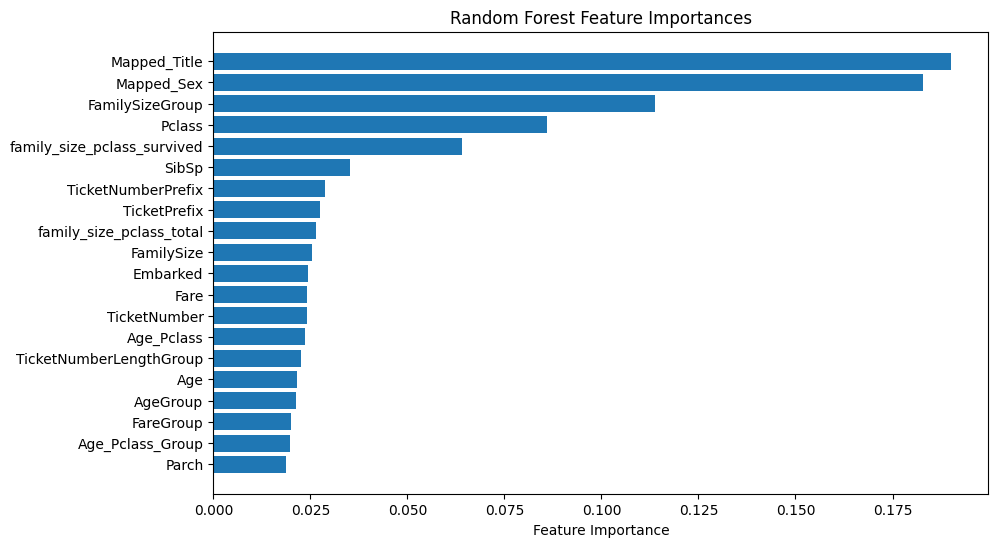

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Loading the model
xg_model_path = '/content/drive/My Drive/titanic/model/xg_0129_1.pkl'
xg_model = joblib.load(xg_model_path)

train_path = '/content/drive/My Drive/titanic/data/internal_train_data_1226_encoded.csv'
train = pd.read_csv(train_path)

# Specify categorical variables
categorical_columns = ['Embarked', 'TicketPrefix', 'TicketNumberPrefix', 'AgeGroup',
                       'Age_Pclass_Group', 'FareGroup', 'FamilySizeGroup']

# Specifying categorical variables
categorical_columns = ['Pclass', 'Embarked', 'Mapped_Title',
                       'TicketPrefix', 'TicketNumber', 'TicketNumberLengthGroup',
                       'TicketNumberPrefix', 'Mapped_Sex', 'AgeGroup',
                       'Age_Pclass_Group', 'FareGroup', 'FamilySizeGroup']

train[categorical_columns] = train[categorical_columns].astype('category')

# Retrieve feature column names
target = 'Survived'
feature_columns = [col for col in train.columns if col != target]

# Obtain feature importance
importances = xg_model.feature_importances_

# Summarize feature importance in a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # Sort by importance in descending order
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()
